In [2]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import ta
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau, StepLR
from torch.utils.data import DataLoader, random_split
import seaborn as sns

In [61]:
data = yf.download(
    "SPY",
    start="1990-01-01",
    end="2021-01-01",
    auto_adjust = True,
    group_by="Ticker",
)

[*********************100%***********************]  1 of 1 completed


In [62]:
data

,Open,High,Low,Close,Volume
Date,,,,,
1993-01-29,25.735681,25.735681,25.607643,25.717390,1003200
1993-02-01,25.735673,25.900293,25.735673,25.900293,480500
1993-02-02,25.882005,25.973461,25.827131,25.955170,201300
1993-02-03,25.991743,26.247820,25.973452,26.229528,529400
1993-02-04,26.320998,26.394162,26.028339,26.339289,531500
...,...,...,...,...,...
2020-12-24,364.514223,365.455032,363.890351,365.425323,26457900
2020-12-28,368.138779,368.980551,367.475286,368.564636,39000400
2020-12-29,370.188752,370.376914,367.237609,367.861511,53680500


In [63]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(-1, 1))
data['price'] = scaler.fit_transform(data['Close'].values.reshape(-1,1))
price = data[['price']]
price

,price
Date,
1993-01-29,-0.998197
1993-02-01,-0.997136
1993-02-02,-0.996818
1993-02-03,-0.995226
1993-02-04,-0.994590
...,...
2020-12-24,0.971972
2020-12-28,0.990179
2020-12-29,0.986101


In [64]:
def split_data(stock, lookback):
    data_raw = stock.to_numpy() # convert to numpy array
    data = []
    
    # create all possible sequences of length seq_len
    for index in range(len(data_raw) - lookback): 
        data.append(data_raw[index: index + lookback])
    
    data = np.array(data);
    test_set_size = int(np.round(0.2*data.shape[0]));
    train_set_size = data.shape[0] - (test_set_size);
    
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    
    x_test = data[train_set_size:,:-1]
    y_test = data[train_set_size:,-1,:]
    
    return [x_train, y_train, x_test, y_test]

In [120]:
lookback = 11 # choose sequence length
x_train, y_train, x_test, y_test = split_data(price, lookback)
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ',y_train.shape)
print('x_test.shape = ',x_test.shape)
print('y_test.shape = ',y_test.shape)

x_train.shape =  (5618, 10, 1)
y_train.shape =  (5618, 1)
x_test.shape =  (1404, 10, 1)
y_test.shape =  (1404, 1)


In [121]:
x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train_lstm = torch.from_numpy(y_train).type(torch.Tensor)
y_test_lstm = torch.from_numpy(y_test).type(torch.Tensor)
y_train_gru = torch.from_numpy(y_train).type(torch.Tensor)
y_test_gru = torch.from_numpy(y_test).type(torch.Tensor)

In [122]:
input_dim = 1
hidden_dim = 100
num_layers = 2
output_dim = 1

In [123]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :]) 
        return out

In [124]:
model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
criterion = torch.nn.MSELoss(reduction='mean')
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)

In [125]:
import time

num_epochs = 200

train_losses = np.zeros(num_epochs)
test_losses = np.zeros(num_epochs)

start_time = time.time()

for t in range(num_epochs):
    y_train_pred = model(x_train)
    y_test_pred = model(x_test)

    train_loss = criterion(y_train_pred, y_train_lstm)
    test_loss = criterion(y_test_pred, y_test_lstm)

    print(f"Epoch {t}: Train MSE: {train_loss.item()}, Test MSE: {test_loss.item()}")
    train_losses[t] = train_loss.item()
    test_losses[t] = test_loss.item()

    optimiser.zero_grad()
    train_loss.backward()
    optimiser.step()

training_time = time.time()-start_time
print("Training time: {}".format(training_time))

Epoch 0: Train MSE: 0.6464553475379944, Test MSE: 0.11122433841228485
Epoch 1: Train MSE: 0.20970754325389862, Test MSE: 0.3055039942264557
Epoch 2: Train MSE: 0.47804415225982666, Test MSE: 1.7213941812515259
Epoch 3: Train MSE: 0.10095863789319992, Test MSE: 0.45925137400627136
Epoch 4: Train MSE: 0.2285800725221634, Test MSE: 0.3058549165725708
Epoch 5: Train MSE: 0.26459771394729614, Test MSE: 0.2753927707672119
Epoch 6: Train MSE: 0.2581174075603485, Test MSE: 0.2789304554462433
Epoch 7: Train MSE: 0.2270948886871338, Test MSE: 0.30332741141319275
Epoch 8: Train MSE: 0.1752038598060608, Test MSE: 0.35371389985084534
Epoch 9: Train MSE: 0.10434228181838989, Test MSE: 0.45328235626220703
Epoch 10: Train MSE: 0.03971054404973984, Test MSE: 0.6669376492500305
Epoch 11: Train MSE: 0.09879174828529358, Test MSE: 1.1153814792633057
Epoch 12: Train MSE: 0.08808035403490067, Test MSE: 1.0969306230545044
Epoch 13: Train MSE: 0.04562203958630562, Test MSE: 0.9010733366012573
Epoch 14: Train 

Epoch 112: Train MSE: 0.0001265934552066028, Test MSE: 0.027059286832809448
Epoch 113: Train MSE: 0.00012599276669789106, Test MSE: 0.026614094153046608
Epoch 114: Train MSE: 0.0001207140667247586, Test MSE: 0.026101715862751007
Epoch 115: Train MSE: 0.00012138362944824621, Test MSE: 0.025487791746854782
Epoch 116: Train MSE: 0.00012071067612851039, Test MSE: 0.02474673092365265
Epoch 117: Train MSE: 0.000117833937110845, Test MSE: 0.023875966668128967
Epoch 118: Train MSE: 0.00011888933659065515, Test MSE: 0.022897502407431602
Epoch 119: Train MSE: 0.00011726146476576105, Test MSE: 0.021848808974027634
Epoch 120: Train MSE: 0.00011503191490191966, Test MSE: 0.020772524178028107
Epoch 121: Train MSE: 0.00011564438318600878, Test MSE: 0.019712813198566437
Epoch 122: Train MSE: 0.00011414012260502204, Test MSE: 0.018715644255280495
Epoch 123: Train MSE: 0.00011360072676325217, Test MSE: 0.017825720831751823
Epoch 124: Train MSE: 0.00011458888184279203, Test MSE: 0.0170784629881382
Epoch 

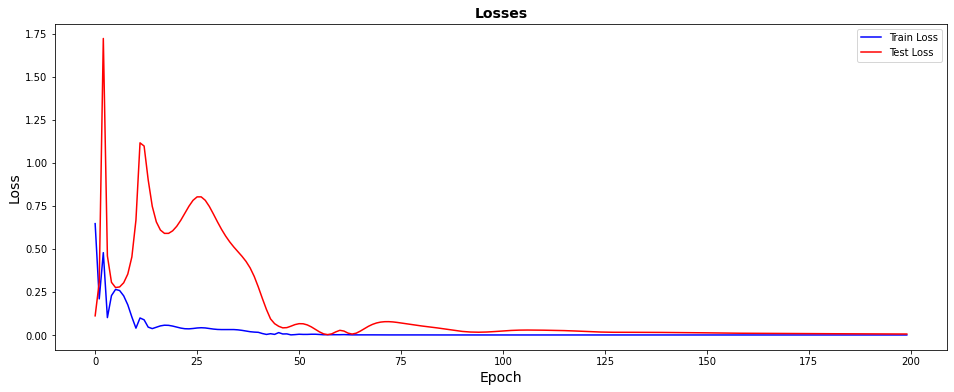

In [126]:
fig = plt.figure(figsize=(20,8))

ax = sns.lineplot(data=train_losses, color='blue', label='Train Loss')
ax = sns.lineplot(data=test_losses, color='red', label='Test Loss')

ax.set_xlabel("Epoch", size = 14)
ax.set_ylabel("Loss", size = 14)
ax.set_title("Losses", size = 14, fontweight='bold')

fig.set_figheight(6)
fig.set_figwidth(16)

In [127]:
import math, time
from sklearn.metrics import mean_squared_error

lstm = []

# make predictions
y_train_pred = model(x_train)
y_test_pred = model(x_test)

# invert predictions
y_train_pred = scaler.inverse_transform(y_train_pred.detach().numpy())
y_train = scaler.inverse_transform(y_train_lstm.detach().numpy())
y_test_pred = scaler.inverse_transform(y_test_pred.detach().numpy())
y_test = scaler.inverse_transform(y_test_lstm.detach().numpy())

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train[:,0], y_train_pred[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test[:,0], y_test_pred[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
lstm.append(trainScore)
lstm.append(testScore)
lstm.append(training_time)

Train Score: 1.69 RMSE
Test Score: 12.89 RMSE


Text(0, 0.5, 'Price (USD)')

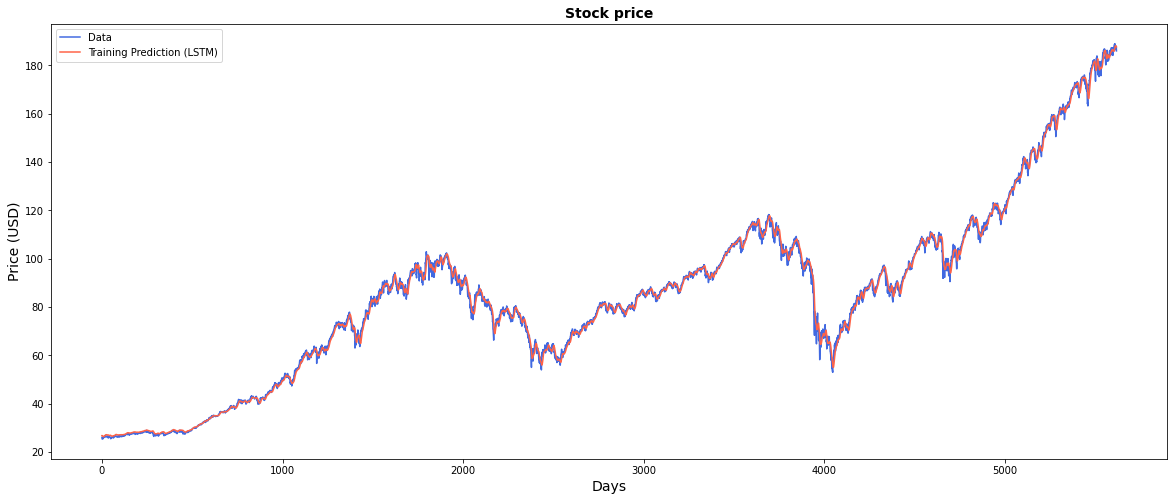

In [128]:
predict = pd.DataFrame(y_train_pred)
original = pd.DataFrame(scaler.inverse_transform(y_train_lstm.detach().numpy()))

fig = plt.figure(figsize=(20,8))
ax = sns.lineplot(x = original.index, y = original[0], label="Data", color='royalblue')
ax = sns.lineplot(x = predict.index, y = predict[0], label="Training Prediction (LSTM)", color='tomato')
ax.set_title('Stock price', size = 14, fontweight='bold')
ax.set_xlabel("Days", size = 14)
ax.set_ylabel("Price (USD)", size = 14)

Text(0, 0.5, 'Price (USD)')

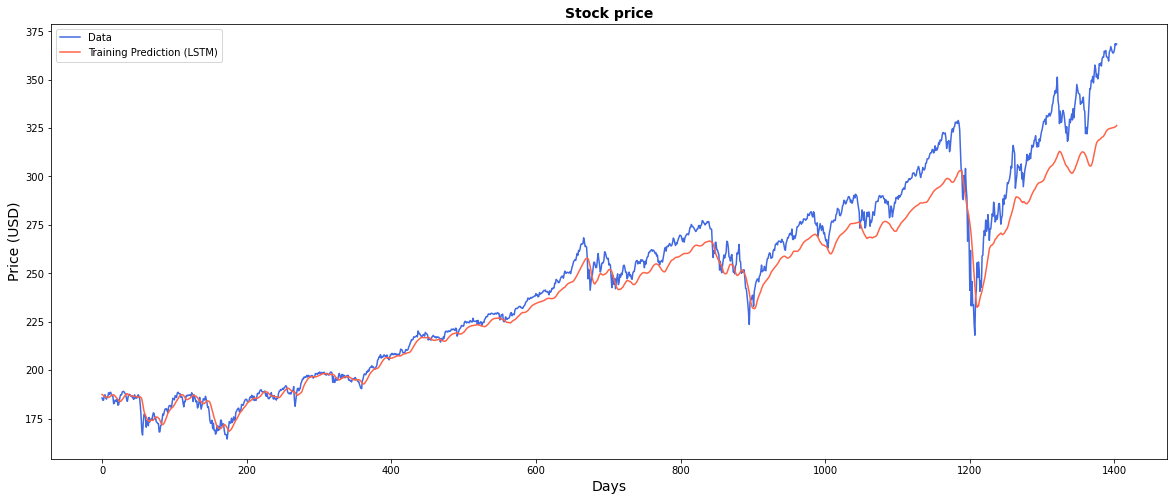

In [152]:
fig = plt.figure(figsize=(20,8))

y_test = pd.DataFrame(y_test)
y_test_pred = pd.DataFrame(y_test_pred)

ax = sns.lineplot(x = y_test.index, y = y_test[0], label="Data", color='royalblue')
ax = sns.lineplot(x = y_test_pred.index, y = y_test_pred[0], label="Training Prediction (LSTM)", color='tomato')
ax.set_title('Stock price', size = 14, fontweight='bold')
ax.set_xlabel("Days", size = 14)
ax.set_ylabel("Price (USD)", size = 14)

In [148]:
actual0 = y_test[1150:1250]
actual_change = ((actual0.shift(-1) - actual0) / actual0) * 100
actual_change

,0
1150,0.242926
1151,0.935194
1152,-0.757227
1153,0.381517
1154,-0.281190
...,...
1245,3.045971
1246,-1.027106
1247,1.698792
1248,-0.690397


In [147]:
pred0 = y_test_pred[1150:1250]
pred_change = ((pred0.shift(-1) - pred0) / pred0) * 100
pred_change

,0
1150,0.155239
1151,0.096785
1152,0.121177
1153,0.124213
1154,0.085380
...,...
1245,0.042571
1246,0.135637
1247,0.168594
1248,0.266575


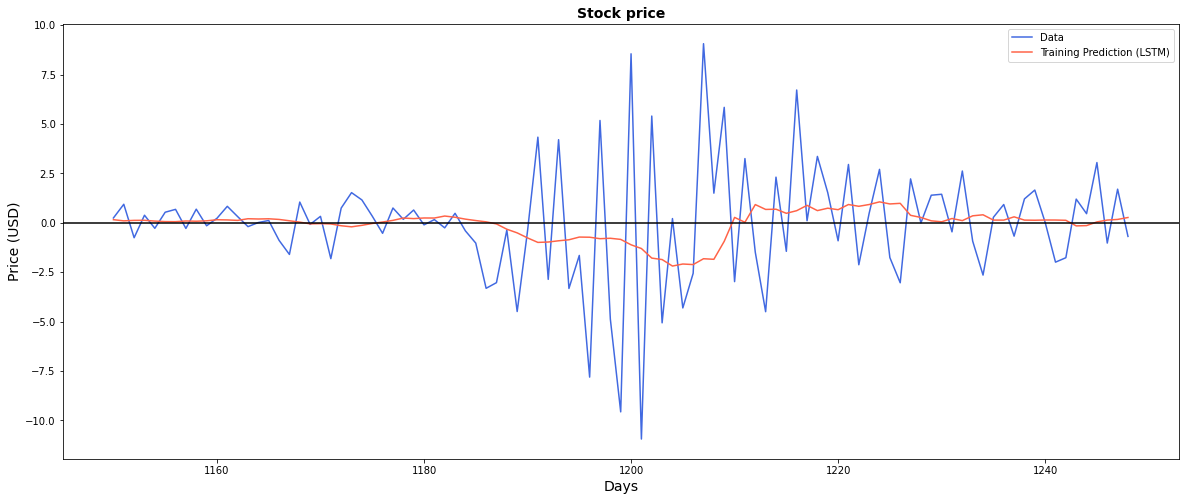

In [151]:
fig = plt.figure(figsize=(20,8))

r1 = actual_change
t1 = pred_change

ax = sns.lineplot(x = r1.index, y = r1[0], label="Data", color='royalblue')
ax = sns.lineplot(x = t1.index, y = t1[0], label="Training Prediction (LSTM)", color='tomato')
ax.set_title('Stock price', size = 14, fontweight='bold')
ax.set_xlabel("Days", size = 14)
ax.set_ylabel("Price (USD)", size = 14)

plt.axhline(y=0, color='black')